In [1]:
import random
import time
import warnings 

warnings.filterwarnings('ignore')

In [2]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [3]:
# Inicialización
import torch

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Definición de constantes 
import os

# esto es para que funcione matplotlib 
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

BATCH_SIZE = 32
EPOCHS = 30
IMAGE_SIZE = 28
DATASET_DIR = './data/'
MODELS_DIR = 'models/'

Using cpu device


In [9]:
from torchvision.io import read_image

sizes = []
for image in os.listdir('./data/images/colored_labels'):
    sizes.append(read_image("./data/images/colored_labels/" + image).shape)
print("Range for inputs with segmentation: ")
print(max(sizes))
print(min(sizes))

sizes = []
for image in os.listdir('./data/images/text_labels'):
    sizes.append(read_image("./data/images/text_labels/" + image).shape)
print("Range for inputs with txt: ")
print(max(sizes))
print(min(sizes))


Range for inputs with segmentation: 
torch.Size([3, 873, 550])
torch.Size([3, 801, 550])
Range for inputs with txt: 
torch.Size([3, 877, 550])
torch.Size([3, 786, 550])


No necesito que me prediga el color exacto de cada categoría, si sabe que es un vestido, luego busco en la tabla su color y listo. 

Para ello, en la siguiente celda creo un codificador y decodificador de one hot a una de las clases, cada una asociada a un color:

In [10]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
classes = pd.read_csv(DATASET_DIR + "/class_dict.csv")

encoder = OneHotEncoder(sparse=False)

codes = encoder.fit_transform(classes["class_name"].values.reshape(-1,1))
codigo_none = codes[0]
codigo_accesorios = codes[1]

uncoded = encoder.inverse_transform([codigo_none, codigo_accesorios])
print("one hot de nada y de accesorios devuelve segun encoder: ", uncoded)

print("Sus colores segun el dataframe: \n", classes[classes["class_name"].isin(uncoded.flatten())][["r","g","b"]])

one hot de nada y de accesorios devuelve segun encoder:  [['none']
 ['accessories']]
Sus colores segun el dataframe: 
     r   g   b
0  69   6  90
1  70  12  95


Dataset para cargar imágenes:

In [37]:
encoder = OneHotEncoder(sparse=False)
codes = encoder.fit_transform(classes["class_name"].values.reshape(-1,1))

encoded_df = pd.concat([classes, pd.Series(list(codes[:]))], axis=1).rename(columns={0: "One-hot"}, inplace=False)
encoded_df["array_value"] = encoded_df[["r","g","b"]].apply(lambda x: np.array([x.r, x.g, x.b]), axis=1)
encoded_df["tensor_value"] = encoded_df[["r","g","b"]].apply(lambda x: torch.tensor([x.r, x.g, x.b]).float(), axis=1)
encoded_df

,class_name,r,g,b,One-hot,array_value,tensor_value
0,none,69,6,90,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[69, 6, 90]","[tensor(69.), tensor(6.), tensor(90.)]"
1,accessories,70,12,95,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[70, 12, 95]","[tensor(70.), tensor(12.), tensor(95.)]"
2,bag,71,18,101,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[71, 18, 101]","[tensor(71.), tensor(18.), tensor(101.)]"
3,belt,72,25,107,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[72, 25, 107]","[tensor(72.), tensor(25.), tensor(107.)]"
4,blazer,72,30,112,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[72, 30, 112]","[tensor(72.), tensor(30.), tensor(112.)]"
5,blouse,72,35,116,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[72, 35, 116]","[tensor(72.), tensor(35.), tensor(116.)]"
6,bodysuit,71,40,120,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[71, 40, 120]","[tensor(71.), tensor(40.), tensor(120.)]"
7,boots,70,47,124,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[70, 47, 124]","[tensor(70.), tensor(47.), tensor(124.)]"
8,bra,69,52,127,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[69, 52, 127]","[tensor(69.), tensor(52.), tensor(127.)]"
9,bracelet,68,57,130,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[68, 57, 130]","[tensor(68.), tensor(57.), tensor(130.)]"


In [38]:
encoded_df["byte_value"] = encoded_df["array_value"].apply(lambda x: x.tobytes())

array_to_onehot = encoded_df[["byte_value", "One-hot"]].set_index('byte_value').to_dict()["One-hot"]
array_to_onehot

{b'E\x00\x00\x00\x00\x00\x00\x00\x06\x00\x00\x00\x00\x00\x00\x00Z\x00\x00\x00\x00\x00\x00\x00': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]),
 b'F\x00\x00\x00\x00\x00\x00\x00\x0c\x00\x00\x00\x00\x00\x00\x00_\x00\x00\x00\x00\x00\x00\x00': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]),
 b'G\x00\x00\x00\x00\x00\x00\x00\x12\x00\x00\x00\x00\x00\x00\x00e\x00\x00\x00\x00\x00\x00\x00': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.,

In [6]:
torch.tensor(1).item()

1

In [152]:

from torchvision.transforms import InterpolationMode
from numpy import int64
from PIL import Image
import random
class ImageCodifier:
    def __call__(self, img):
        img = np.asarray(img, dtype=int64)
        codified = np.apply_along_axis(lambda pixel: array_to_onehot[pixel.tobytes()], 2, img)
        return torch.tensor(codified)

    def __repr__(self):
        return self.__class__.__name__+'()'
    

class CustomClothingDataset(Dataset):
    def __init__(self, root_dir, input_dir='images/colored_labels', 
                 labels_dir='labels/pixel_level_labels_colored',
                 transform_input=transforms.Compose([
                     transforms.Resize((864, 576), interpolation=InterpolationMode.NEAREST), #size mayor de las imagenes, para todas iguales sin perder información, esta ligeramente reducido para ser divisible por 16 (necesario para U-net
                     transforms.Lambda(lambda x: x / 255), # reescalo de 0 a 1
                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),# normalizo
                 ]),
                 transform_labels=transforms.Compose([
                    transforms.Resize((864, 576), interpolation=InterpolationMode.NEAREST),
                    ImageCodifier()
                 ]),
                 transform_augmentation = transforms.RandomHorizontalFlip(p=1)            
                 ):
                        
        self.root_dir = root_dir
        self.input_dir = input_dir
        self.labels_dir = labels_dir
        self.transform_input = transform_input
        self.transform_labels = transform_labels
        self.transform_augmentation = transform_augmentation
        self.image_files = os.listdir(os.path.join(root_dir, self.input_dir))
        self.label_files = os.listdir(os.path.join(root_dir, self.labels_dir))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        input = read_image(os.path.join(self.root_dir, self.input_dir, self.image_files[idx])).float()
        label = Image.open(os.path.join(self.root_dir, self.labels_dir, self.label_files[idx])) # en un inicio no las leemos como tensores
        if self.transform_input:        
            input = self.transform_input(input)
        if self.transform_labels:
            label = self.transform_labels(label)
        if self.transform_augmentation and random.choice([True, False]):
            return self.transform_augmentation(input), self.transform_augmentation(label)
        return input, label
            


Revertimos la codificacion para afianzar que es correcta:

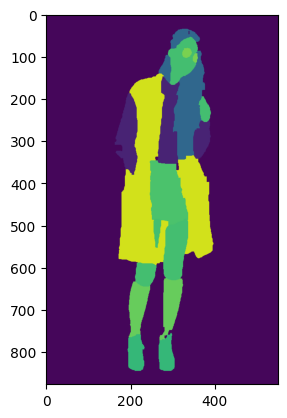

In [153]:
import numpy as np
onehot_to_array = {v.tobytes(): k for k, v in array_to_onehot.items()}
label = CustomClothingDataset(root_dir=DATASET_DIR).__getitem__(0)[1]

codified = np.apply_along_axis(lambda pixel: np.frombuffer(onehot_to_array[pixel.tobytes()], dtype=np.int64), 2, np.array(label))
plt.imshow(codified)

Cantidad de imágenes:  1004


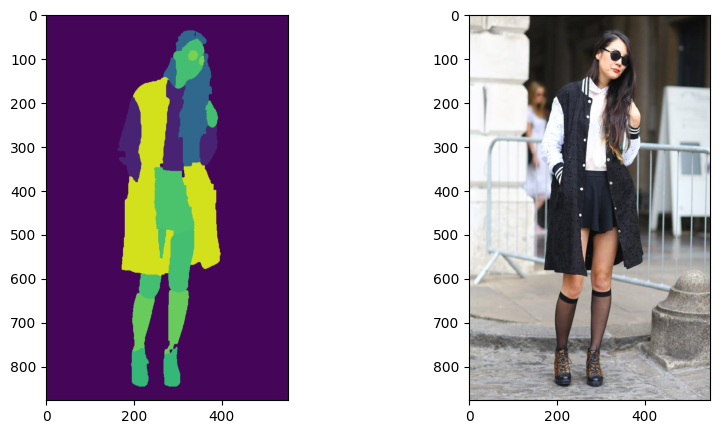

In [174]:
from matplotlib import pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

dataset = CustomClothingDataset(root_dir=DATASET_DIR,
                                transform_input=transforms.Compose([
                     transforms.Resize((864,550), interpolation=InterpolationMode.NEAREST), #size mayor de las imagenes, para todas iguales sin perder información
                 ]),
                                transform_labels=transforms.Compose([transforms.Resize((877,550)),
                                                                    transforms.PILToTensor()
    ])
                                )
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
print("Cantidad de imágenes: ", len(data_loader.dataset))
for image, label in data_loader:
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(label[0].int(), (1, 2, 0)))
    plt.subplot(1, 2, 2)
    plt.imshow(np.transpose(image[0].int(), (1, 2, 0)))
    plt.show()
    break

## Implementación 1
### Modelo U-NET

Creación del modelo:

Hay que coger imagenes con el mismo grosor y altura para meterlos como input en la u-net, no vale `877x550` sino al mejor `560x560` para evitar coger el mayor porque puede generar ruido en la imagen, y tambien porque ese valor es divisible por 2 para pooling y unpooling, se prefiere compactarlo que generar ruido.

In [7]:
import torch
import torch.nn as nn

""" Convolutional block:
    It follows a two 3x3 convolutional layer, each followed by a batch normalization and a relu activation.
"""
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

""" Encoder block:
    It consists of an conv_block followed by a max pooling.
    Here the number of filters doubles and the height and width half after every block.
"""
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

""" Decoder block:
    The decoder block begins with a transpose convolution, followed by a concatenation with the skip
    connection from the encoder block. Next comes the conv_block.
    Here the number filters decreases by half and the height and width doubles.
"""
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x


class build_unet(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(3, 70)
        self.e2 = encoder_block(70, 140)
        self.e3 = encoder_block(140, 280)
        self.e4 = encoder_block(280, 560)

        """ Bottleneck """
        self.b = conv_block(560, 1120)

        """ Decoder """
        self.d1 = decoder_block(1120, 560)
        self.d2 = decoder_block(560, 280)
        self.d3 = decoder_block(280, 140)
        self.d4 = decoder_block(140, 70)

        """ Classifier """
        self.outputs = nn.Conv2d(70, 52, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        """ Classifier """
        outputs = self.outputs(d4)

        return outputs


#inputs = torch.randn((2, 3, 560, 560)).to(device)
inputs = torch.randn((2, 3, 864, 576))#.to(device)
model = build_unet()#.to(device)
y = model(inputs)
print(y.shape)

one time
torch.Size([2, 560, 108, 72])
torch.Size([2, 560, 108, 72])
one time
torch.Size([2, 280, 216, 144])
torch.Size([2, 280, 216, 144])
one time
torch.Size([2, 140, 432, 288])
torch.Size([2, 140, 432, 288])
one time
torch.Size([2, 70, 864, 576])
torch.Size([2, 70, 864, 576])
torch.Size([2, 52, 864, 576])


In [175]:
dataset = CustomClothingDataset(root_dir=DATASET_DIR) 
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE) 

In [177]:
from torch.utils.data import random_split

full_dataset = CustomClothingDataset(root_dir=DATASET_DIR)

train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

loss_fn = torch.nn.CrossEntropyLoss()


In [182]:
from classes import ModelTrainer, EarlyStopper

model = build_unet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
TrainNNObject = ModelTrainer(model, optimizer, loss_fn, 10, EarlyStopper(1, 0.1), device)
TrainNNObject.train_and_val(train_loader, val_loader)
TrainNNObject.draw_results()
TrainNNObject.test(test_loader)

OutOfMemoryError: CUDA out of memory. Tried to allocate 4.03 GiB. GPU 0 has a total capacty of 12.00 GiB of which 0 bytes is free. Of the allocated memory 14.62 GiB is allocated by PyTorch, and 1.34 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF